In [1]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.6 MB/s eta 0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolv

# Import Modules

In [2]:
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

# Load UTKFace (extract age & gender)

In [3]:
from tqdm import tqdm
import os

IMG_SIZE = 128
DATASET_PATH = "/kaggle/input/utkface-new/UTKFace"

paths, ages, genders = [], [], []

for file in tqdm(os.listdir(DATASET_PATH)):
    try:
        age, gender, _ = file.split("_", 2)

        img_path = os.path.join(DATASET_PATH, file)

        paths.append(img_path)          # ✅ store path
        ages.append(int(age))
        genders.append(int(gender))
    except:
        continue


100%|██████████| 23708/23708 [00:00<00:00, 630459.28it/s]


In [4]:
# # Numpy array code
# X = np.array(images)
# y_age = np.array(ages)
# y_gender = np.array(genders)

# print("Total samples:", len(X))

In [5]:
df = pd.DataFrame({
    "image": paths,
    "age": ages,
    "gender": genders
})

print("Total samples:", len(df))
df.head()

Total samples: 23708


,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


# **Data Preprocessing**

# Check images before training (imshow)

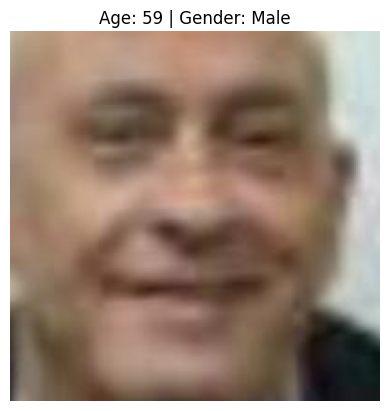

In [6]:
idx = random.randint(0, len(df)-1)

row = df.iloc[idx]
img_path = row["image"]
age = row["age"]
gender = "Male" if row["gender"] == 0 else "Female"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(f"Age: {age} | Gender: {gender}")
plt.axis("off")
plt.show()


# Model Building

In [7]:
# 3️⃣ Train Test Split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# Data Augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator_raw = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="image",
    y_col=["gender", "age"],  # multi-output
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="raw",       # IMPORTANT for regression + multi-output
    shuffle=True
)

val_generator_raw = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="image",
    y_col=["gender", "age"],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="raw",  
    shuffle=False
)


Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [10]:
# Create a wrapper generator

def make_multi_output(gen):
    while True:
        x, y = next(gen)     # y shape: (batch_size, 2) = (3, 2) #Batch size = number of rows processed together

        y_dict = {
            "gender": y[:, 0],   # first column
            "age": y[:, 1]       # second column
        }

        yield x, y_dict


train_generator = make_multi_output(train_generator_raw)
val_generator   = make_multi_output(val_generator_raw)



In [11]:
# VGG16 Transfer Learning Model

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.summary()

I0000 00:00:1768554321.652621      20 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768554321.653284      20 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Freeze base

# for layer in base_model.layers:
#     layer.trainable = False

base_model.trainable = False


base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# Functional

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

gender_output = Dense(1, activation="sigmoid", name="gender")(x)
age_output = Dense(1, activation="linear", name="age")(x)

model = Model(inputs=base_model.input, outputs=[gender_output, age_output])


In [14]:
# compile

model.compile(
    optimizer="adam",
    loss={"gender": "binary_crossentropy", "age": "mse"},
    metrics={"gender": "accuracy", "age": "mae"}
)

model.summary()


# Use this compile

# model.compile(
#     optimizer="adam",
#     loss={"gender": "binary_crossentropy", "age": "mse"},
#     metrics={"gender": ["accuracy"], "age": ["mae"]}
# )

# model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
# Train the model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator_raw),
    validation_steps=len(val_generator_raw),
    epochs=10
)

Epoch 1/10
  2/593 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - age_loss: 1329.2735 - age_mae: 31.9154 - gender_accuracy: 0.4453 - gender_loss: 0.8613 - loss: 1330.1348  

I0000 00:00:1768554331.915362      76 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 164s 263ms/step - age_loss: 211.8507 - age_mae: 11.0812 - gender_accuracy: 0.5835 - gender_loss: 0.9769 - loss: 212.8791 - val_age_loss: 142.0573 - val_age_mae: 9.2258 - val_gender_accuracy: 0.5654 - val_gender_loss: 0.6551 - val_loss: 143.0508
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 95s 160ms/step - age_loss: 162.4437 - age_mae: 9.7201 - gender_accuracy: 0.6163 - gender_loss: 0.6733 - loss: 163.1480 - val_age_loss: 129.0935 - val_age_mae: 8.6604 - val_gender_accuracy: 0.6900 - val_gender_loss: 0.6025 - val_loss: 130.0963
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 93s 157ms/step - age_loss: 151.6064 - age_mae: 9.3326 - gender_accuracy: 0.6368 - gender_loss: 0.6456 - loss: 152.2323 - val_age_loss: 123.7116 - val_age_mae: 8.2255 - val_gender_accuracy: 0.7229 - val_gender_loss: 0.5812 - val_loss: 124.2927
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 92s 156ms/step - age_loss: 145.6274 - age_mae: 9.1104 - gender_accuracy: 0.6390 - gender_loss: 0.6495 - loss: 146.1677 -

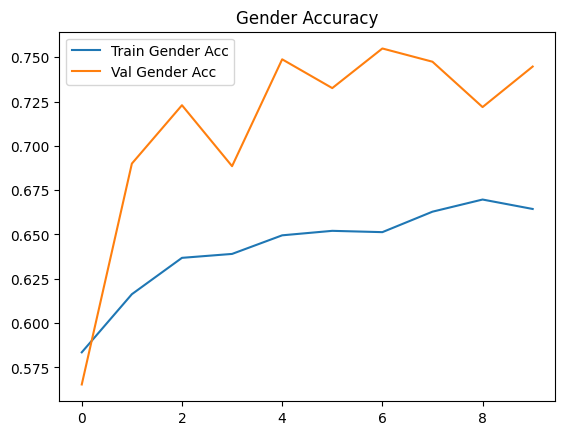

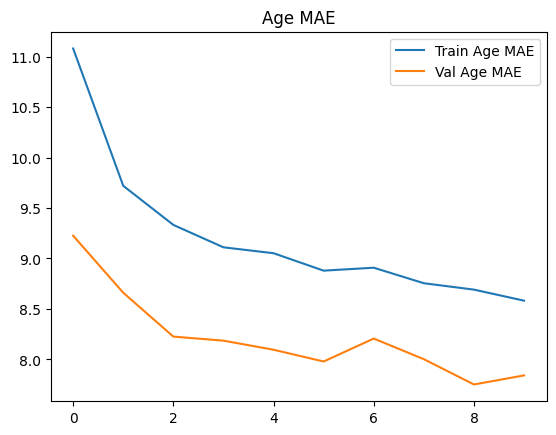

In [16]:
# Plots

# Gender Accuracy
plt.plot(history.history['gender_accuracy'], label='Train Gender Acc')
plt.plot(history.history['val_gender_accuracy'], label='Val Gender Acc')
plt.title("Gender Accuracy")
plt.legend()
plt.show()

# Age MAE
plt.plot(history.history['age_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_mae'], label='Val Age MAE')
plt.title("Age MAE")
plt.legend()
plt.show()


# Model Evaluation

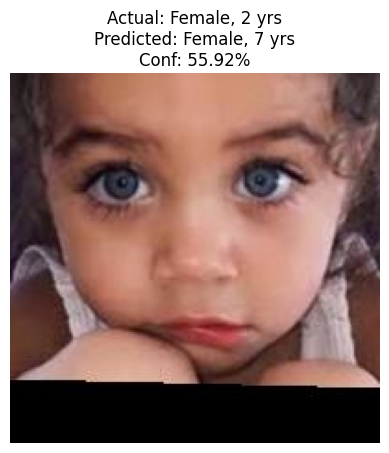

In [17]:
# Prediction for single image

# pick one random sample from validation dataframe
idx = random.randint(0, len(df_val) - 1)
row = df_val.iloc[idx]

img_path = row["image"]
true_age = row["age"]
true_gender = "Male" if row["gender"] == 0 else "Female"

# load & preprocess
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
img_norm = img_resized / 255.0

# predict
gender_pred, age_pred = model.predict(
    np.expand_dims(img_norm, axis=0),
    verbose=0
)

#pred_gender = "Male" if gender_pred[0][0] > 0.5 else "Female"
pred_gender = "Female" if gender_pred[0][0] > 0.5 else "Male"
pred_age = int(age_pred[0][0])

# confidence for gender
# gender_conf = (
#     gender_pred[0][0] * 100 if pred_gender == "Male"
#     else (1 - gender_pred[0][0]) * 100
# )

gender_conf = (
    gender_pred[0][0] * 100 if pred_gender == "Female"
    else (1 - gender_pred[0][0]) * 100
)


# show
plt.imshow(img_rgb)
plt.title(
    f"Actual: {true_gender}, {true_age} yrs\n"
    f"Predicted: {pred_gender}, {pred_age} yrs\n"
    f"Conf: {gender_conf:.2f}%"
)
plt.axis("off")
plt.show()


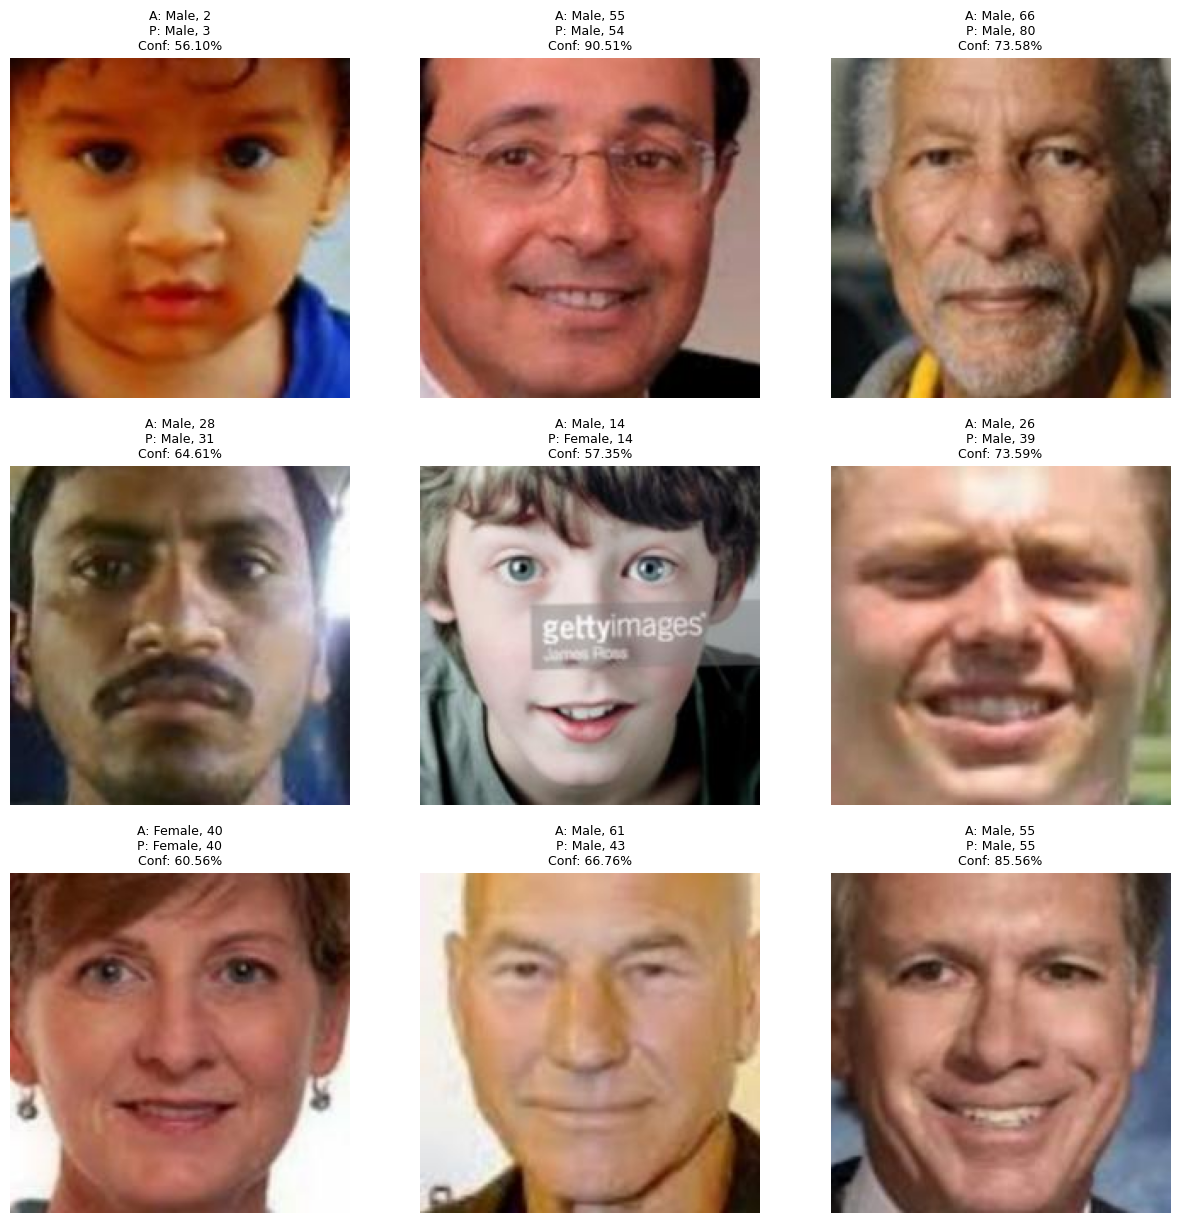

In [18]:
# Prediction for multiple image

plt.figure(figsize=(15,15))

for i in range(9):
    # pick a random sample from validation dataframe
    idx = random.randint(0, len(df_val)-1)
    row = df_val.iloc[idx]

    img_path = row["image"]
    true_age = row["age"]
    true_gender = "Male" if row["gender"] == 0 else "Female"

    # load & preprocess
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized / 255.0

    # predict
    gender_pred, age_pred = model.predict(
        np.expand_dims(img_norm, axis=0),
        verbose=0
    )

    #pred_gender = "Male" if gender_pred[0][0] > 0.5 else "Female"
    pred_gender = "Female" if gender_pred[0][0] > 0.5 else "Male"
    pred_age = int(age_pred[0][0])

    # gender confidence
    # gender_conf = (
    #     gender_pred[0][0]*100 if pred_gender=="Male"
    #     else (1-gender_pred[0][0])*100
    # )
    gender_conf = (
    gender_pred[0][0]*100 if pred_gender=="Female"
    else (1-gender_pred[0][0])*100
    )


    # plot
    plt.subplot(3,3,i+1)
    plt.imshow(img_rgb)
    plt.title(
        f"A: {true_gender}, {true_age}\n"
        f"P: {pred_gender}, {pred_age}\n"
        f"Conf: {gender_conf:.2f}%",
        fontsize=9
    )
    plt.axis("off")

plt.show()


In [19]:
# Test on Outside Image

# IMG_SIZE = 128
# img_path = "/kaggle/input/my-images/test.jpg"   # change

# img_bgr = cv2.imread(img_path)
# if img_bgr is None:
#     print("❌ Image not found!")
# else:
#     img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#     img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
#     img_norm = img_resized / 255.0
#     img_input = np.expand_dims(img_norm, axis=0)

#     gender_pred, age_pred = model.predict(img_input, verbose=0)

    
#     gender = "Female" if gender_pred[0][0] > 0.5 else "Male"
#     age = int(age_pred[0][0])

#     plt.imshow(img_rgb)
#     plt.title(f"{gender}, {age} yrs")
#     plt.axis("off")
#     plt.show()


In [20]:
# Save 

# model.save("age_gender_vgg16_model_fix.h5")

In [21]:
#model.save("age_gender_vgg16_model.keras")

In [22]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)

# print("Keras version:", tf.keras.__version__)
